##### Visualize Mixing Depth and PAR over full hindcast <br>
G Oldford
May 2023

Purpose: generate indices of productivity for phyto groups using P-I curves
         and functional response to mixing or stratification
         
Data in: PAR, mixing as ASC (monthly, clipped to ECOSPACE - NC's after initial invest)
         - P-I curve params


Notes: 


To-do: 
- May 14 2023 - the PAR attr keeps it's original name even after enviro function is applied - fix this


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import math

import cartopy as cp
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

In [3]:
## Load data as-is into xarray dataset and then row-wise avg as xr

path_data = "../data/output/RUN203/ECOSPACE/"
mxng_p = "NEMO_prepped_as_ASC/{var}/"
tmp_p = "NEMO_prepped_as_ASC/{var}/"
li_p = "ECOSPACE_in_PAR3_Sal10m/{var}/"
k_p = "ECOSPACE_in_PAR3_Sal10m/RUN203_{var}/"
sal_p = "NEMO_prepped_as_ASC/{var}/"

path_data2 = "../data/forcing/"
li_p2 = "RDRS_light_monthly_ASC/{var}/"
wi_p = "RDRS_wind_monthly_ASC/{var}/"

# template file names w/ var names
v_f = {"MixedLyrZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "MixingTurboZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean10m":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",  
       "PAR-VarZ-VarK":path_data + li_p + "{var}_{year}_{month}.asc",  
       "Kfromsal":path_data + k_p + "RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "zvelocMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "solar_rad":path_data2 + li_p2 + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc",
       "u10m":path_data2 + wi_p + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc",
       "v10m":path_data2 + wi_p + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc"
      }

yr_strt = 1980
yr_end = 2017
months_d = {"01": 1, "02": 2, "03": 3,"04": 4,"05": 5,"06": 6,"07": 7,"08": 8,"09": 9,"10": 10,"11": 11,"12": 12}
months = list(range(1,12))

rows = 151
cols = 93
months = 12

skiprows = 6 # header

time = pd.date_range(start='{yr_strt}-01-01'.format(yr_strt=yr_strt), 
                              end='{yr_end}-12-01'.format(yr_end=yr_end), 
                              freq='MS')+ pd.DateOffset(days=14)

# empty ds for all 
ds = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# create empty variable with correct shape
for v in v_f:
    ds[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows, cols)),
        dims=('time', 'row', 'col'),
        attrs={'description': f'{v} data'}
    )

# load the data
for v in v_f:
    attribute = v_f[v]
    for y in range(yr_strt, yr_end+1):
        for m in sorted(months_d.keys()):
            f_n = v_f[v].format(var=v,year=y,month=m)
            with open(f_n) as f:
                data = np.loadtxt(f,skiprows=skiprows)
                
                # homogenize what nans are
                data[data==-9999.0]=['nan']
                data[data==0.0]=['nan']
                
                # fix issue with bottom left area in map
                data[140:,:15]=['nan']
                
                ds[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    data,
                    dims=('row', 'col'),
                    attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
                          

### Calculate response to light for diatoms, dinoflagellates, flagellates, pico, nano, bac

In [126]:
# based on Sarmiento & Gruber, 2006 (p. 135; fig 4.2.9) which is based on Parsons et al., 1984 (p. 79) and 
# Parsons references 
dia_I_opt = 23
din_I_opt = 40
fla_I_opt = 15

# eqn for P-I curve based on Steele form see Merico et al., 2004, p. 1822, Appendix A, Eqn A.3
# I/I_opt * exp(1 - I/I_opt)
# note there is an excel sheet where I experimented with different curvatures


# empty ds for PI response 
ds_PI = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'PI response',
    }
)

# create empty variable with correct shape
for v in v_f:
    if v == "PAR-VarZ-VarK":
        ds_PI[v] = xr.DataArray(
            np.nan*np.zeros((len(time), rows, cols)),
            dims=('time', 'row', 'col'),
            attrs={'description': f'PI response values'}
        )

# load the data
for v in v_f:
    if v == "PAR-VarZ-VarK":
        attribute = v_f[v]
        for y in range(yr_strt, yr_end+1):
            for m in sorted(months_d.keys()):
                f_n = v_f[v].format(var=v,year=y,month=m) # open the monthly ASC
                
                with open(f_n) as f:
                    data = np.loadtxt(f,skiprows=skiprows)

                    # homogenize what nans are
                    data[data==-9999.0]=['nan']
                    data[data==0.0]=['nan']

                    # fix issue with bottom left area in map
                    data[140:,:15]=['nan']
                    
                    ds_PI[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                        data,
                        dims=('row', 'col'),
                        attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                    )

# see above for info                
dia_PI = ds_PI / dia_I_opt * math.exp(1) ** (1 - ds_PI/dia_I_opt) 
din_PI = ds_PI / din_I_opt * math.exp(1) ** (1 - ds_PI/din_I_opt) 
fla_PI = ds_PI / fla_I_opt * math.exp(1) ** (1 - ds_PI/fla_I_opt) 
#I/I_opt * exp(1 - I/I_opt)

### Parameterize the mixing / mixed depth functional response for PP

In [12]:
mix_var = "MixedLyrZ"
#mix_var = "MixingTurboZ"

# empty ds for MIXING response (0 - 1) 
ds_MI = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Mixing response',
    }
)

# create empty variable with correct shape
for v in v_f:
    if v == mix_var:
        ds_MI[v] = xr.DataArray(
            np.nan*np.zeros((len(time), rows, cols)),
            dims=('time', 'row', 'col'),
            attrs={'description': f'Mixing response values'}
        )

# load the data
for v in v_f:
    if v == mix_var:
        attribute = v_f[v]
        for y in range(yr_strt, yr_end+1):
            for m in sorted(months_d.keys()):
                f_n = v_f[v].format(var=v,year=y,month=m) # open the monthly ASC
                
                with open(f_n) as f:
                    data = np.loadtxt(f,skiprows=skiprows)

                    # homogenize what nans are
                    data[data==-9999.0]=['nan']
                    data[data==0.0]=['nan']

                    # fix issue with bottom left area in map
                    data[140:,:15]=['nan']
                    
                    ds_MI[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                        data,
                        dims=('row', 'col'),
                        attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                    )

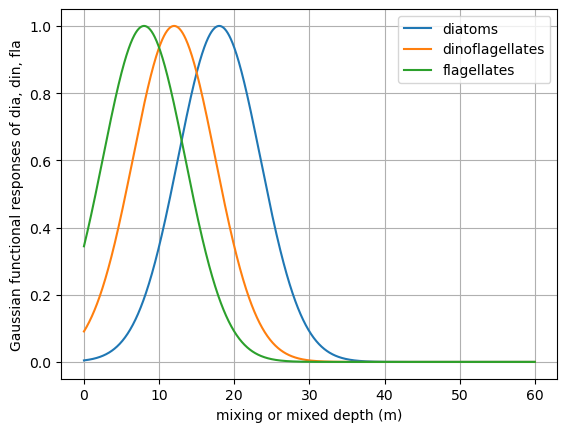

In [170]:
# these are guesses based on the climatology of mixed layer (or mixing layer) from previous notebook
# opt = mean for gaussian function
dia_M_opt = 18
din_M_opt = 12
fla_M_opt = 8

# var = variance for tuning gaussian
dia_M_var = 30
din_M_var = 30
fla_M_var = 30


# visual for tuning (function used is in next cell below)
x = np.linspace(0, 60,1200)

# apply gaussian function
dia_y = np.exp(-0.5 * ((x - dia_M_opt) ** 2) / dia_M_var) / np.sqrt(2 * np.pi * dia_M_var)
din_y = np.exp(-0.5 * ((x - din_M_opt) ** 2) / din_M_var) / np.sqrt(2 * np.pi * din_M_var)
fla_y = np.exp(-0.5 * ((x - fla_M_opt) ** 2) / fla_M_var) / np.sqrt(2 * np.pi * fla_M_var)

# rescale to 1.0
dia_y /= np.max(dia_y)
din_y /= np.max(din_y)
fla_y /= np.max(fla_y)

plt.plot(x, dia_y, label="diatoms")
plt.plot(x, din_y, label="dinoflagellates")
plt.plot(x, fla_y, label="flagellates")
plt.xlabel('mixing or mixed depth (m)')
plt.ylabel('Gaussian functional responses of dia, din, fla')
plt.grid(True)
plt.legend()
plt.show()

In [171]:
def gaussian_fnc(ds_MI, M_opt, M_var, mix_var):
    MI = math.exp(1) ** (-0.5 * ((ds_MI - M_opt) ** 2) / M_var) / math.sqrt(2 * math.pi * M_var)
    
    # rescale out of 1.0
    reshaped_data = MI[mix_var].stack(points=('row', 'col'))
    flattened_data = reshaped_data.values.flatten()
    
    MI = MI / np.nanmax(flattened_data)
    return(MI)

dia_MI = gaussian_fnc(ds_MI, dia_M_opt, dia_M_var, mix_var)
din_MI = gaussian_fnc(ds_MI, din_M_opt, din_M_var, mix_var)
fla_MI = gaussian_fnc(ds_MI, fla_M_opt, fla_M_var, mix_var)

# create an 'phytoplankton environmental index'
# just to get an idea of whether there might be a trend
# prior to dynamic ecosystem model application
dia_EI['dia_ei'] = dia_MI[mix_var] * dia_PI['PAR-VarZ-VarK']
din_EI['din_ei'] = din_MI[mix_var] * din_PI['PAR-VarZ-VarK']
fla_EI['fla_ei'] = fla_MI[mix_var] * fla_PI['PAR-VarZ-VarK']

# already scaled to be 0-1

### N-S trend analysis

In [172]:
v_ei = ["dia_ei", "din_ei", "fla_ei"]# enviro indices names

# second dataset to store the row-wise averages 
ds_NS = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'dataset for N-S analysis',
    }
)

# empty variable with correct shape for ds2
for v in v_ei:
    ds_NS[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows)),
        dims=('time','row'),
        attrs={'description': f'{v} avg row-wise'}
    )
    
# Calculates row-wise averages for each attribute and each month
for v in v_ei:
    for y in range(yr_strt, yr_end+1):   
        for m in sorted(months_d.keys()):
            # Select the data for this attribute and month
            
            if (v == "dia_ei"):
                data = dia_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            elif (v == "din_ei"):
                data = din_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            elif (v == "fla_ei"):
                data = fla_EI[v].sel(time=f'{y}-{m}'.format(y=y,m=m))
            else:
                print("error")
                break

            # Calculate the row-wise average and print it
            row_avg = data.mean(dim='col')
            
            ds_NS[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    row_avg[0],
                    dims=('row'),
                    attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )

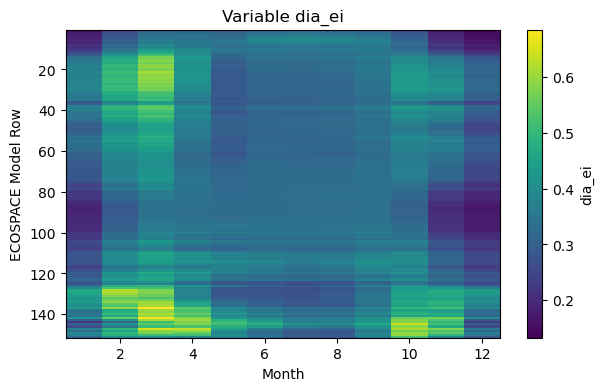

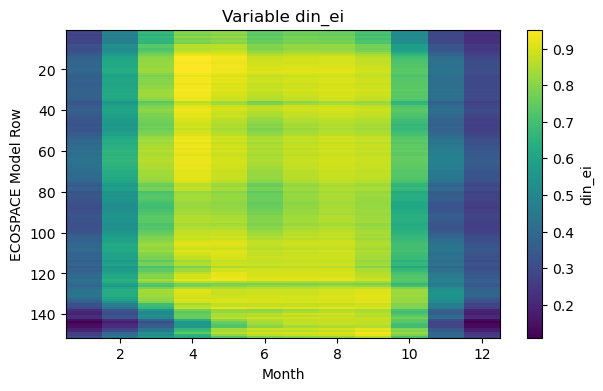

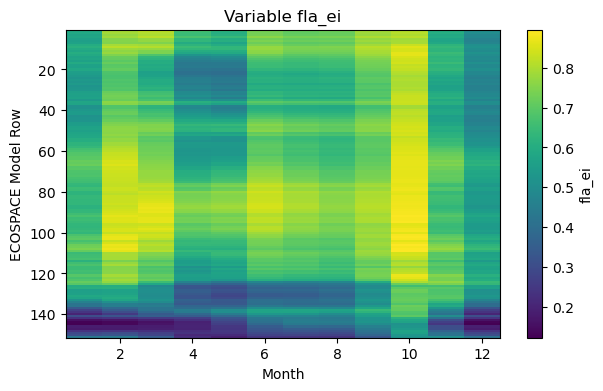

In [173]:
# climatologies
for v in v_ei:
    v1 = ds_NS[v]
    q = v1.groupby('time.month').mean(dim='time').T

    fig, axs = plt.subplots(figsize = (7,4))
    xr.plot.pcolormesh(q, ax = axs)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)

    axs.invert_yaxis()
    axs.set_xlabel('Month')
    axs.set_ylabel('ECOSPACE Model Row')

### Deviations from the clim along N-S

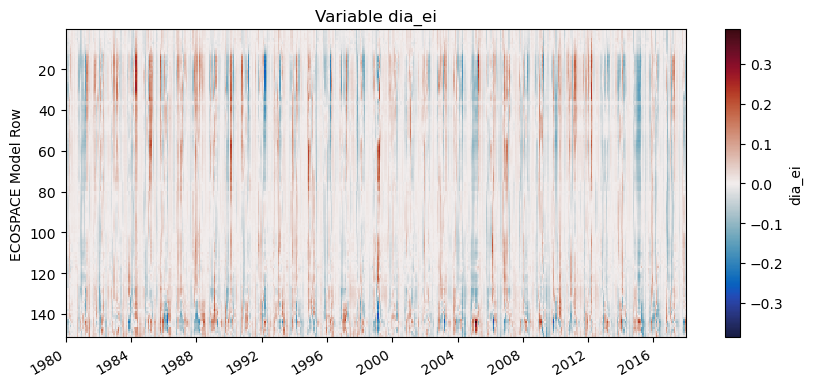

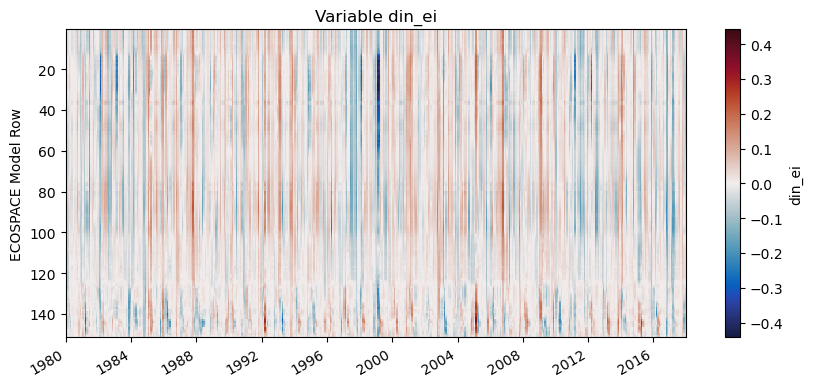

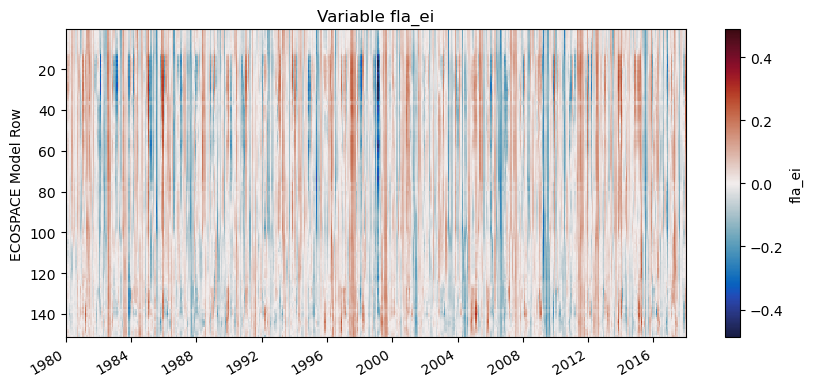

In [174]:
#var_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

for v in v_ei:
    
    if (v == "dia_ei"):
        v1 = ds_NS[v]
    elif (v == "din_ei"):
        v1 = ds_NS[v]
    elif (v == "fla_ei"):
        v1 = ds_NS[v]
    else:
        print("error")
        break
    
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    #anom =  anom.isel(row = (anom.row > 0) & (anom.row < 30)) # change rows, explore n-s trends
    
    fig, axs = plt.subplots(figsize = (10,4))
    xr.plot.pcolormesh(anom, ax = axs,cmap = cm.cm.balance)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('')
    axs.set_ylabel('ECOSPACE Model Row')
    
    # lin regress trend
    tyr = np.arange(yr_strt,yr_end+1,1)
    fig, axs = plt.subplots(figsize = (10,4))
    
    mean_anom =  anom_season.isel(row = (anom_season.row > 0) & (anom_season.row < 151)).mean(dim = 'row') # change rows, explore n-s trends
    axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    
    x = tyr[~np.isnan(mean_anom.values)]
    y = mean_anom.values[~np.isnan(mean_anom.values)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m*10} [units]/decade')
    axs.legend(loc = 'best')
    axs.axhline(y=0)
    axs.set_title('Variable {v}'.format(v=v))

### simple linear regressions to look at trends

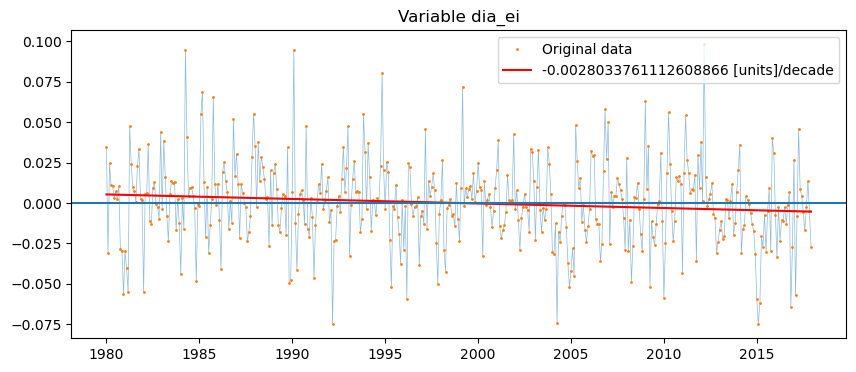

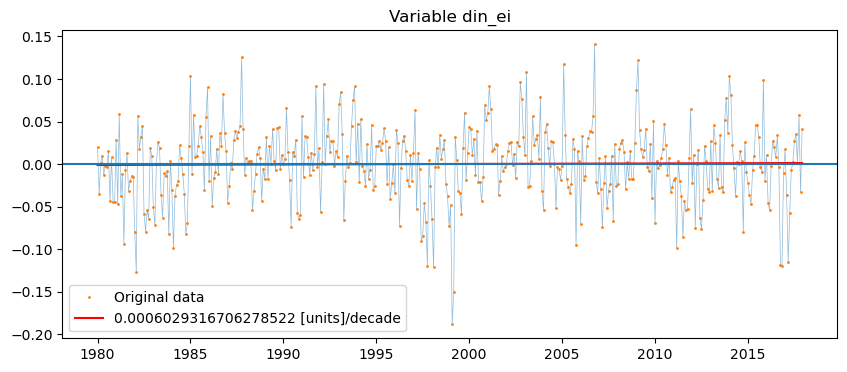

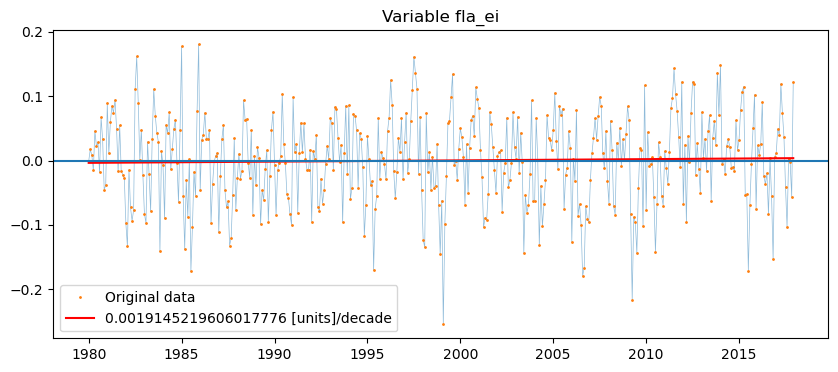

In [175]:
for v in v_ei:
    if (v == "dia_ei"):
        v1 = ds_NS[v]
    elif (v == "din_ei"):
        v1 = ds_NS[v]
    elif (v == "fla_ei"):
        v1 = ds_NS[v]
    else:
        print("error")
        break
    
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    mean_anom =  anom.isel(row = (anom.row > 0) & (anom.row < 151)).mean(dim = 'row') # change rows, explore n-s trends
    
    tyr = np.arange(yr_strt,yr_end+1,(1/12))
    
    fig, axs = plt.subplots(figsize = (10,4))
    
    axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    
    # trend
    x = tyr[~np.isnan(mean_anom.values)]
    y = mean_anom.values[~np.isnan(mean_anom.values)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m*10} [units]/decade')
    axs.legend(loc = 'best')
    axs.axhline(y=0)
    axs.set_title('Variable {v}'.format(v=v))